In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import time
from datetime import timedelta
from datetime import datetime

import glob
from matplotlib import image

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils

plt.rcParams.update({'font.size': 10})
SEED = 3
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
!gdown --id "1aFjcSk9hBzsHusrjO3UjCg4xQo9Ubdr1"
!unzip "categorized_products"

In [3]:
class ToTensor(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)
class ToTensor255(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

In [ ]:
productsPath = "categorized_products/"
l = len(productsPath)
categories = [c[l:] for c in glob.glob(productsPath + '/*')]
products = dict()
for categ in categories:
  products[categ] = glob.glob(productsPath + "/" + categ + '/*.jpg')

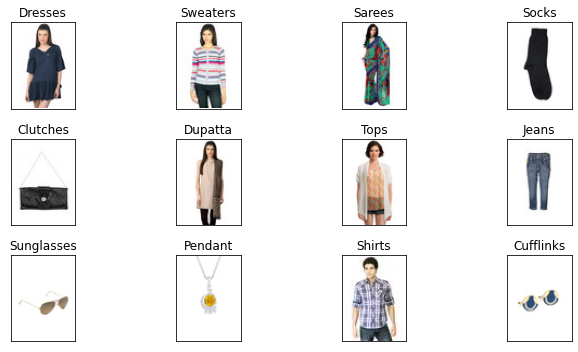

In [ ]:
def displayImages(width, height):
  fig = plt.figure(figsize=(10,5))
  for i in range(0, width * height):
    img = image.imread(products[categories[i]][0])
    plt.subplot(height, width, i+1)
    label = categories[i]
    plt.title(label)    
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.imshow(img)
  plt.show()

displayImages(4, 3)

In [4]:
class Model(nn.Module):
  def __init__(self, classNum, act=F.relu):
    super(Model, self).__init__()

    self.layer1 = nn.Linear(1 * 80 * 60, 64 * 20 * 15)
    self.act1 = act

    self.layer2 = nn.Linear(64 * 20 * 15, 128 * 8 * 6)
    self.act2 = act

    self.layer3 = nn.Linear(128 * 8 * 6, 256 * 4 * 3)
    self.act3 = act

    self.layer4 = nn.Linear(256 * 4 * 3, 80)
    self.act4 = act

    self.layer5 = nn.Linear(80, classNum)


  def forward(self, x):

    x = x.view(x.size(0), -1)

    x = self.layer1(x)
    x = self.act1(x)

    x = self.layer2(x)
    x = self.act2(x)

    x = self.layer3(x)
    x = self.act3(x)

    x = self.layer4(x)
    x = self.act4(x)

    x = self.layer5(x)
    return x

In [5]:
class NeuralNetwork:
  def __init__(self, path, transform, device, batchSize = 64):
    self.dataset = ImageFolder(path
                      , transform=transform)
    self.totalNum = len(self.dataset)
    self.classes = self.dataset.classes
    data = dict()
    for d in self.dataset:
      if (d[1] not in data):
        data[d[1]] = []
      data[d[1]].append(d[0])
    for d in data:
      np.random.shuffle(data[d])
    self.trainData = []
    self.testData = []
    for categ in data:
      self.trainData = list(set().union(self.trainData, [(x, categ) for x in data[categ][:int(len(data[categ])*0.8)]]))
      self.testData = list(set().union(self.testData, [(x, categ) for x in data[categ][int(len(data[categ])*0.8):]]))
    self.trainLoader = torch.utils.data.DataLoader(self.trainData, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               worker_init_fn = np.random.seed(SEED),
                                               num_workers = 0)
    self.testLoader = torch.utils.data.DataLoader(self.testData, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               worker_init_fn = np.random.seed(SEED),
                                               num_workers = 0)
    self.device = device
    self.model = Model(len(self.classes))
    self.model = self.model.to(self.device)
    self.testAccuracies = dict()
    self.trainAccuracies = dict()
    self.losses = list()

  def setLoaders(self, batchSize):
    self.trainLoader = torch.utils.data.DataLoader(self.trainData, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               worker_init_fn = np.random.seed(SEED),
                                               num_workers = 0)
    self.testLoader = torch.utils.data.DataLoader(self.testData, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               worker_init_fn = np.random.seed(SEED),
                                               num_workers = 0)
    
  def showSampleImage(self, train = True):
    dataIter = iter(self.trainLoader)
    images, label = dataIter.next()
    plt.imshow(images[0], cmap="gray")
    print('the class of this product is %s' % (self.dataset.classes[label[0]]))

  def getNumberDistribution(self, loader):
    totalCategoryCount = {self.classes[i] : 0 for i in range(len(self.classes))}
    for _, labels in loader:
      for label in labels:
        totalCategoryCount[ self.classes[label] ] += 1
    return totalCategoryCount

  def plotNumberDistribution(self, mode = "all"):
    if (mode == "test"):
      loader = self.testLoader
    if (mode == "train"):
      loader = self.trainLoader
    else:
      loader = torch.utils.data.DataLoader(self.dataset)
    totalCategoryCount = {k: v for k, v in sorted(self.getNumberDistribution(loader).items(), 
                                                  key=lambda item: item[1], 
                                                  reverse=True)} 
    keys = totalCategoryCount.keys()
    values = totalCategoryCount.values()
    fig = plt.figure(figsize=(20,6))
    plt.tight_layout()
    plt.xticks(rotation=80)
    plt.title("Distribution of Classes")
    plt.xlabel("class")
    plt.ylabel("number")
    plt.bar(keys, values, color="crimson")
    plt.show()
  
  
  def fit(self, numEpochs = 10, learningRate = 0.01, momentum = 0, act = F.relu, weightDecay = 0, refreshModel = True):
    if (refreshModel):
      self.model = Model(len(self.classes))
      self.model = self.model.to(self.device)
    self.testAccuracies = dict()
    self.trainAccuracies = dict()
    self.losses = list()
    losses = list()
    criterion = nn.CrossEntropyLoss()
    if (momentum != 0):
      optimizer = torch.optim.SGD(self.model.parameters(), lr=learningRate, momentum=momentum, weight_decay=weightDecay)
    else:
      optimizer = torch.optim.SGD(self.model.parameters(), lr=learningRate, weight_decay=weightDecay)
    totalTime = 0.
    totals = dict()
    corrects = dict()
    for epoch in range(numEpochs):
      trainLoss = 0.
      d1 = datetime.now()
      for images, labels in self.trainLoader:
        images = images.to(self.device)
        labels = labels.to(self.device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = self.model(images)

        _, predicted = torch.max(outputs.data, 1)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        trainLoss += loss.item()


      averageLoss = trainLoss / len(self.trainLoader)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      totalTime += seconds
      print('epoch %d, trainLoss: %.3f, time elapsed: %s seconds' % 
            (epoch + 1, averageLoss, seconds))
      losses.append(averageLoss)
    print('total training time: %.3f minutes' % (totalTime / 60))
    self.losses = losses

  def testModelAccuracy(self, train = False):
    totals = dict()
    corrects = dict()
    if (train):
      loader = self.trainLoader
    else:
      loader = self.testLoader
    with torch.no_grad():
      for images, labels in loader:
        outputs = self.model(images.to(self.device))
        _, predicted = torch.max(outputs.data, 1)
        for label in labels.numpy():
          if self.classes[label] not in totals:
            totals[self.classes[label]] = 0
          totals[self.classes[label]] += 1
        for i in range(len(predicted.to('cpu').numpy())):
          label = self.classes[labels.numpy()[i]]
          if label not in corrects:
            corrects[label] = 0
          corrects[label] += (predicted.to('cpu').numpy()[i] == labels.numpy()[i])
    
    if (train):
      self.trainAccuracies = {label: float(corrects[label] / totals[label]) for label in corrects.keys()}
    else:
      correct = sum(list(corrects.values()))
      total = sum((totals.values()))
      accuracy = 100 * correct / total
      print('Accuracy: {}%'.format(accuracy))
      self.testAccuracies = {label: float(corrects[label] / totals[label]) for label in corrects.keys()}
    
  def plotClassAccuracy(self):
    trainAccuracyDict = {k: v for k, v in sorted(self.trainAccuracies.items(), 
                                                  key=lambda item: item[1], 
                                                  reverse=True)} 
    keys = trainAccuracyDict.keys()
    testAccuracyDict = {k: self.testAccuracies[k] for k in keys} 
    testValues = testAccuracyDict.values()
    trainValues = trainAccuracyDict.values()
    labels = ['train', 'test']
    fig = plt.figure(figsize=(20,6))
    plt.tight_layout()
    plt.xticks(rotation=80)
    plt.title("Accuracy of Classes")
    plt.xlabel("class")
    plt.ylabel("accuracy")
    plt.bar(keys, trainValues, color="crimson", align='edge', width=-0.4)
    plt.bar(keys, testValues, color="gold", width=0.4)
    plt.legend(labels, loc='upper right')
    plt.show()

  def getModelParam(self, layerNum, bias = False):
    layers = {1: self.model.layer1, 2: self.model.layer2,
              3: self.model.layer3, 4: self.model.layer4,
              5: self.model.layer5}
    if (bias == True):
      return layers[layerNum].bias
    return layers[layerNum].weight

  def printAllModelParams(self):
    for param in self.model.parameters():
      print(param.data)

  def setModelParam(self, layerNum, value, bias = False):
    layers = {1: self.model.layer1, 2: self.model.layer2,
              3: self.model.layer3, 4: self.model.layer4,
              5: self.model.layer5}
    with torch.no_grad():
      if (bias == True):
        layers[layerNum].bias.fill_(value)
      else:
        layers[layerNum].weight.fill_(value)
  
  def setAllModelParams(self, value):
    for i in range(1, 6):
      self.setModelParam(i, value)
      self.setModelParam(i, value, bias = True)
  
  def evaluate(self):
    self.testModelAccuracy()
    self.testModelAccuracy(train = True)
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Loss Over Time")
    plt.plot(self.losses, color = "crimson")
    plt.show()

    self.plotClassAccuracy()


  

In [6]:
transform = transforms.Compose([transforms.Grayscale(),
                                ToTensor()
                               ]
                              )
transform255 = transforms.Compose([transforms.Grayscale(),
                                ToTensor255()
                               ]
                              )
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

the class of this product is Tshirts


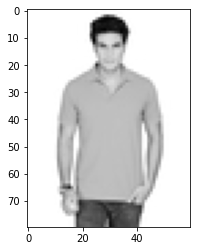

In [ ]:
neuralNetwork255 = NeuralNetwork("categorized_products/", transform255, device)
neuralNetwork255.showSampleImage()

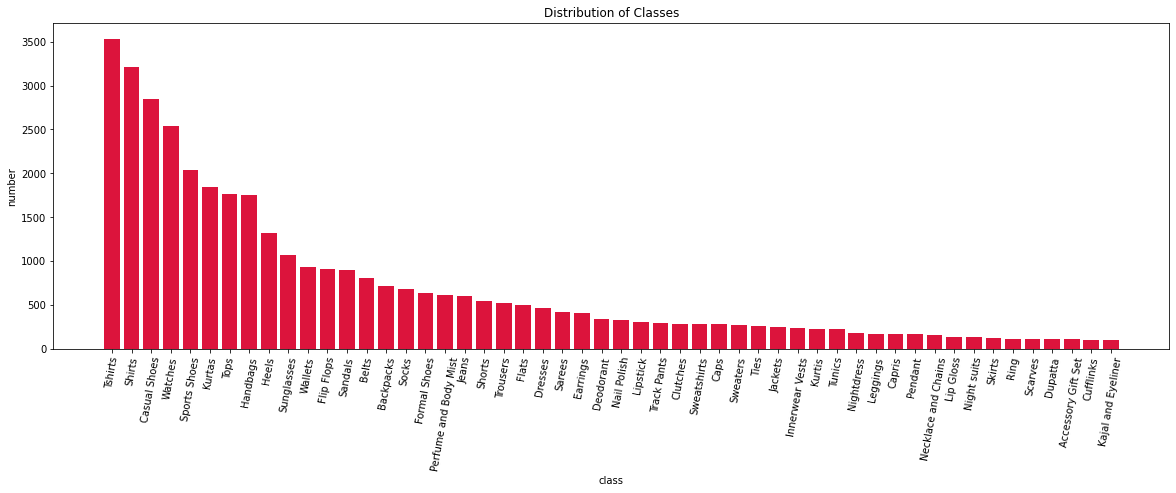

In [ ]:
neuralNetwork255.plotNumberDistribution()

epoch 1, trainLoss: nan, time elapsed: 11.994602 seconds
epoch 2, trainLoss: nan, time elapsed: 11.856942 seconds
epoch 3, trainLoss: nan, time elapsed: 11.848051 seconds
epoch 4, trainLoss: nan, time elapsed: 11.843671 seconds
epoch 5, trainLoss: nan, time elapsed: 11.845548 seconds
epoch 6, trainLoss: nan, time elapsed: 11.836886 seconds
epoch 7, trainLoss: nan, time elapsed: 11.841967 seconds
epoch 8, trainLoss: nan, time elapsed: 11.874886 seconds
epoch 9, trainLoss: nan, time elapsed: 11.831399 seconds
epoch 10, trainLoss: nan, time elapsed: 11.829673 seconds
total training time: 1.977 minutes
Accuracy: 0.3078158458244111%


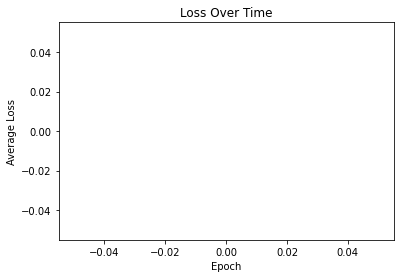

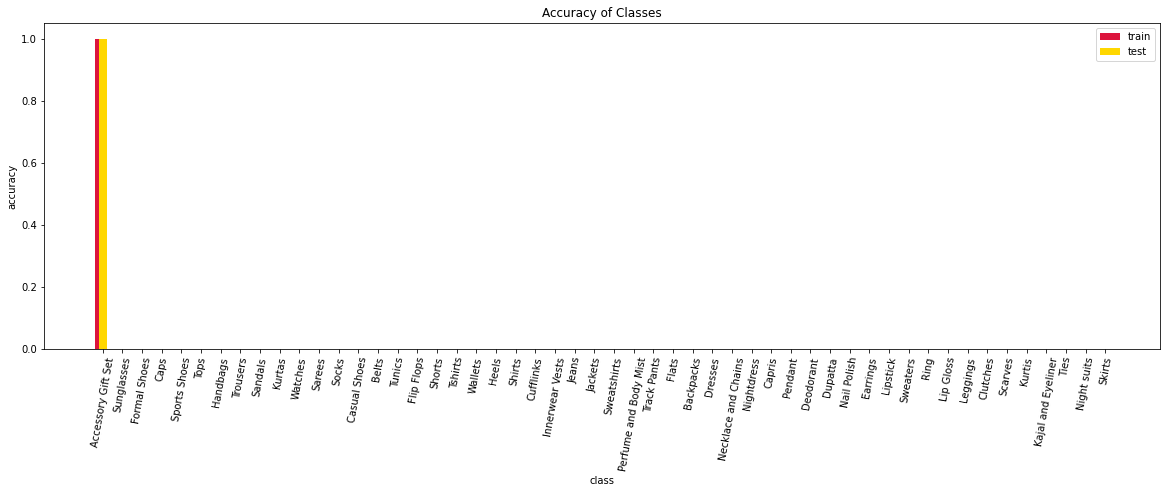

In [ ]:
neuralNetwork255.fit()
neuralNetwork255.evaluate()

In [7]:
neuralNetwork = NeuralNetwork("categorized_products/", transform, device)

In [ ]:
for param in neuralNetwork.model.parameters():
    print(param.shape)

torch.Size([19200, 4800])
torch.Size([19200])
torch.Size([6144, 19200])
torch.Size([6144])
torch.Size([3072, 6144])
torch.Size([3072])
torch.Size([80, 3072])
torch.Size([80])
torch.Size([52, 80])
torch.Size([52])


In [ ]:
neuralNetwork.printAllModelParams()

tensor([[ 0.0037,  0.0066, -0.0120,  ...,  0.0022,  0.0070,  0.0120],
        [ 0.0123, -0.0089, -0.0144,  ..., -0.0111,  0.0063,  0.0071],
        [-0.0052, -0.0005, -0.0043,  ...,  0.0088,  0.0042, -0.0140],
        ...,
        [-0.0072, -0.0043,  0.0070,  ..., -0.0020,  0.0137, -0.0130],
        [ 0.0077, -0.0055,  0.0105,  ...,  0.0019, -0.0055,  0.0011],
        [-0.0044, -0.0012,  0.0037,  ..., -0.0123,  0.0050, -0.0107]],
       device='cuda:0')
tensor([ 0.0077,  0.0134, -0.0123,  ..., -0.0011, -0.0002,  0.0028],
       device='cuda:0')
tensor([[ 0.0039, -0.0023, -0.0049,  ...,  0.0040, -0.0033,  0.0029],
        [ 0.0009,  0.0020, -0.0005,  ..., -0.0023,  0.0030, -0.0027],
        [-0.0040, -0.0071, -0.0016,  ...,  0.0034,  0.0004, -0.0056],
        ...,
        [ 0.0018,  0.0047,  0.0037,  ..., -0.0048,  0.0034, -0.0029],
        [ 0.0033,  0.0011,  0.0068,  ..., -0.0022,  0.0064,  0.0054],
        [ 0.0038,  0.0004, -0.0024,  ...,  0.0017,  0.0009, -0.0048]],
       device='

epoch 1, trainLoss: 3.391, time elapsed: 11.837268 seconds
epoch 2, trainLoss: 2.641, time elapsed: 11.839478 seconds
epoch 3, trainLoss: 2.185, time elapsed: 11.832725 seconds
epoch 4, trainLoss: 1.878, time elapsed: 11.836219 seconds
epoch 5, trainLoss: 1.688, time elapsed: 11.842856 seconds
epoch 6, trainLoss: 1.564, time elapsed: 11.838753 seconds
epoch 7, trainLoss: 1.472, time elapsed: 11.836784 seconds
epoch 8, trainLoss: 1.404, time elapsed: 11.821121 seconds
epoch 9, trainLoss: 1.335, time elapsed: 11.830961 seconds
epoch 10, trainLoss: 1.292, time elapsed: 11.854963 seconds
total training time: 1.973 minutes
Accuracy: 53.69379014989293%


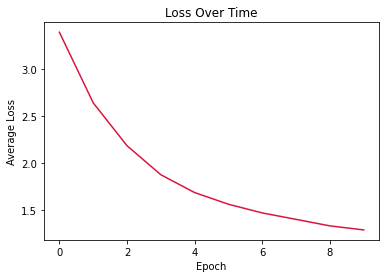

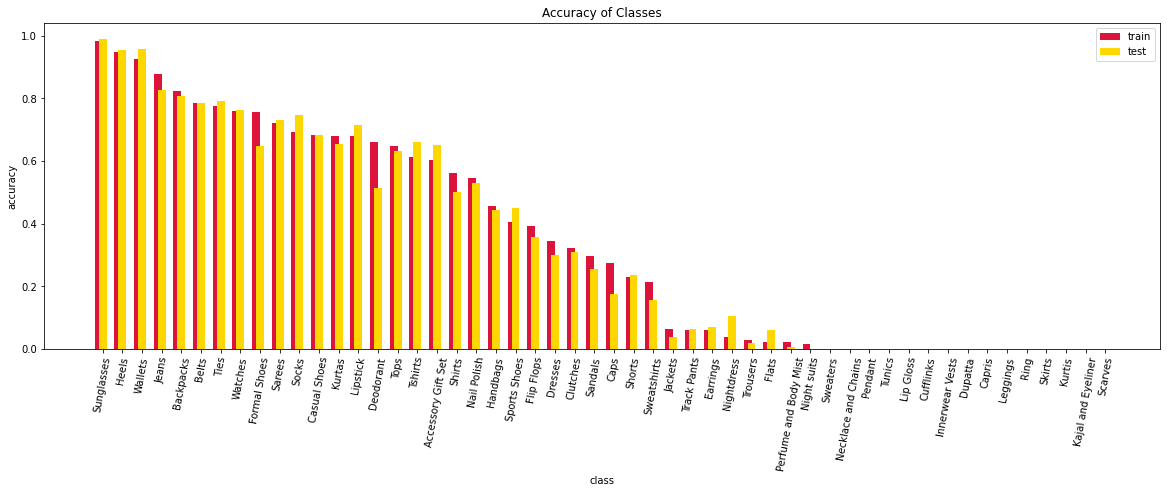

In [ ]:
neuralNetwork.fit()
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.895, time elapsed: 11.858007 seconds
epoch 2, trainLoss: 3.798, time elapsed: 11.845422 seconds
epoch 3, trainLoss: 3.720, time elapsed: 11.845558 seconds
epoch 4, trainLoss: 3.660, time elapsed: 11.85233 seconds
epoch 5, trainLoss: 3.615, time elapsed: 11.827119 seconds
epoch 6, trainLoss: 3.582, time elapsed: 11.845024 seconds
epoch 7, trainLoss: 3.556, time elapsed: 11.852699 seconds
epoch 8, trainLoss: 3.538, time elapsed: 11.833127 seconds
epoch 9, trainLoss: 3.523, time elapsed: 11.832874 seconds
epoch 10, trainLoss: 3.512, time elapsed: 11.831516 seconds
total training time: 1.974 minutes
Accuracy: 9.461991434689507%


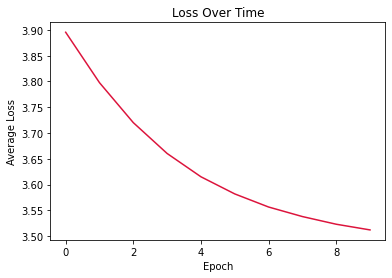

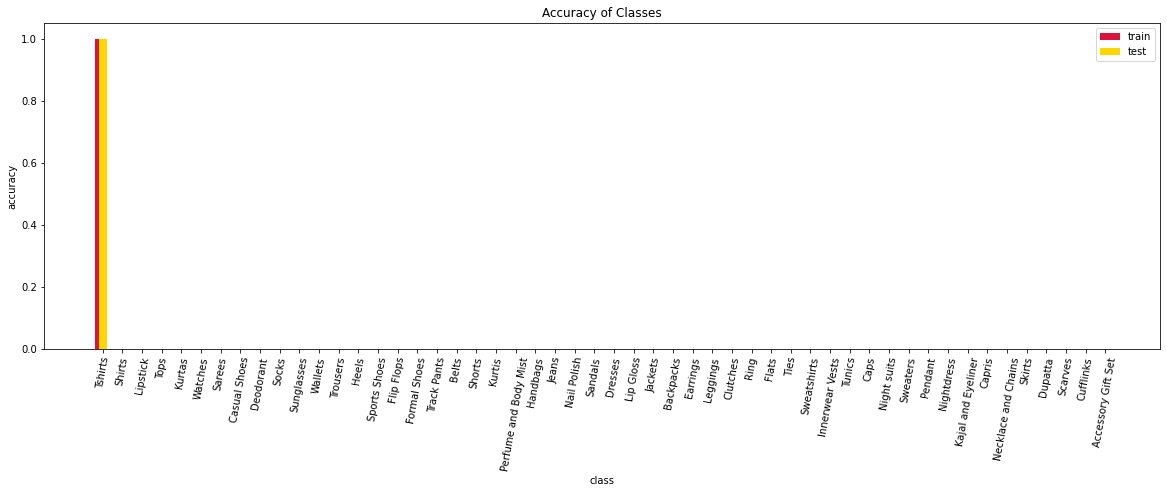

In [ ]:
neuralNetwork.setAllModelParams(0.)
neuralNetwork.fit(refreshModel=False)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.861, time elapsed: 11.837657 seconds
epoch 2, trainLoss: 2.018, time elapsed: 11.814684 seconds
epoch 3, trainLoss: 1.693, time elapsed: 11.842607 seconds
epoch 4, trainLoss: 1.492, time elapsed: 11.837095 seconds
epoch 5, trainLoss: 1.355, time elapsed: 11.843706 seconds
epoch 6, trainLoss: 1.261, time elapsed: 11.842302 seconds
epoch 7, trainLoss: 1.179, time elapsed: 11.844251 seconds
epoch 8, trainLoss: 1.120, time elapsed: 11.834376 seconds
epoch 9, trainLoss: 1.072, time elapsed: 11.832929 seconds
epoch 10, trainLoss: 1.041, time elapsed: 11.845678 seconds
total training time: 1.973 minutes
Accuracy: 61.349036402569595%


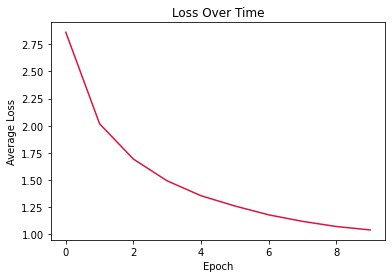

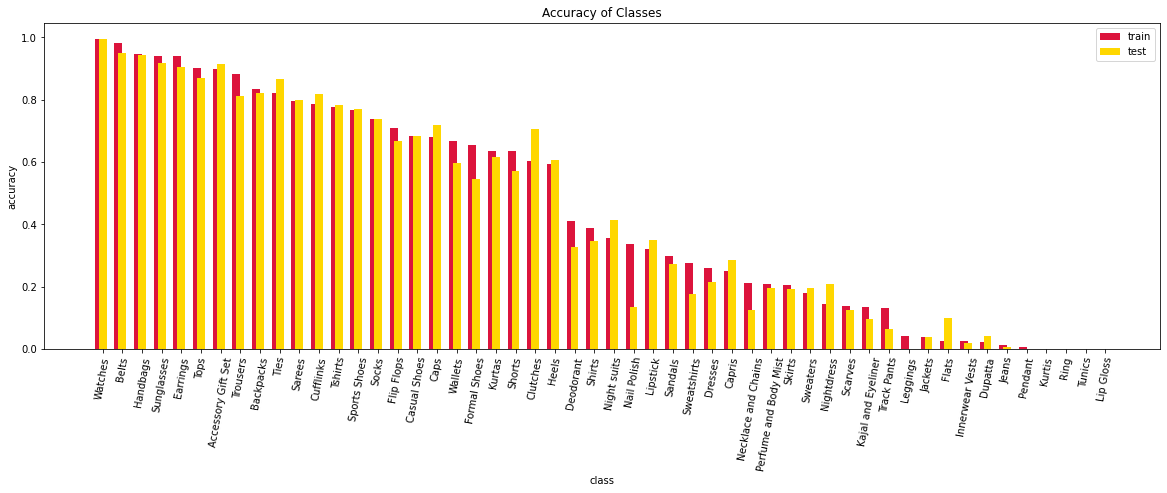

In [ ]:
neuralNetwork.fit(learningRate=0.04)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.764, time elapsed: 11.837572 seconds
epoch 2, trainLoss: 1.933, time elapsed: 11.843519 seconds
epoch 3, trainLoss: 1.632, time elapsed: 11.834004 seconds
epoch 4, trainLoss: 1.441, time elapsed: 11.835865 seconds
epoch 5, trainLoss: 1.315, time elapsed: 11.842878 seconds
epoch 6, trainLoss: 1.223, time elapsed: 11.831545 seconds
epoch 7, trainLoss: 1.178, time elapsed: 11.832368 seconds
epoch 8, trainLoss: 1.102, time elapsed: 11.846036 seconds
epoch 9, trainLoss: 1.062, time elapsed: 11.836538 seconds
epoch 10, trainLoss: 1.040, time elapsed: 11.84206 seconds
total training time: 1.973 minutes
Accuracy: 59.06049250535332%


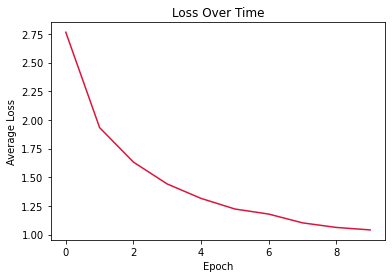

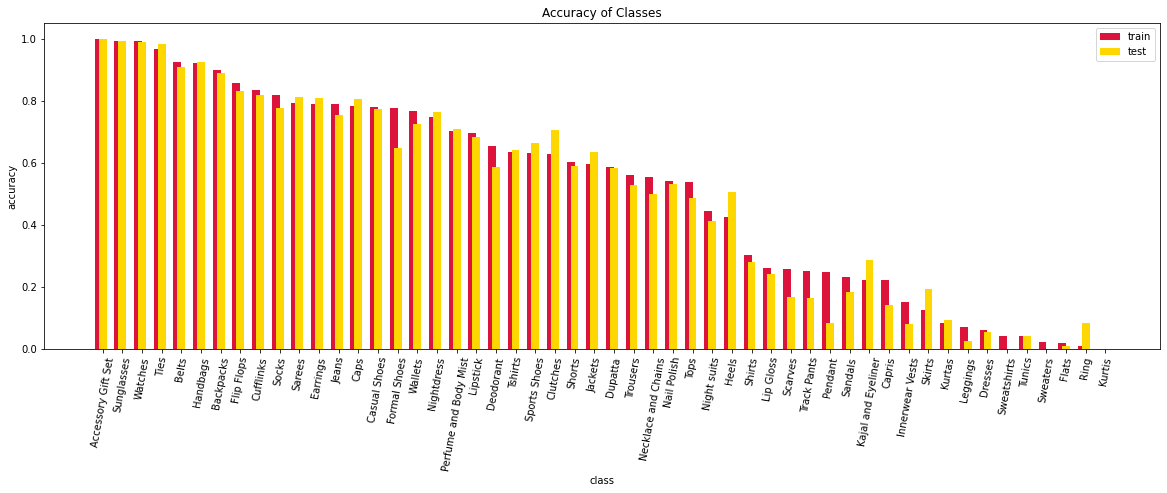

In [ ]:
neuralNetwork.fit(learningRate=0.05)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.762, time elapsed: 11.833518 seconds
epoch 2, trainLoss: 1.971, time elapsed: 11.835034 seconds
epoch 3, trainLoss: 1.649, time elapsed: 11.824 seconds
epoch 4, trainLoss: 1.433, time elapsed: 11.835981 seconds
epoch 5, trainLoss: 1.332, time elapsed: 11.837797 seconds
epoch 6, trainLoss: 1.225, time elapsed: 11.844118 seconds
epoch 7, trainLoss: 1.163, time elapsed: 11.83883 seconds
epoch 8, trainLoss: 1.112, time elapsed: 11.835187 seconds
epoch 9, trainLoss: 1.049, time elapsed: 11.843402 seconds
epoch 10, trainLoss: 1.007, time elapsed: 11.83461 seconds
total training time: 1.973 minutes
Accuracy: 64.54764453961457%


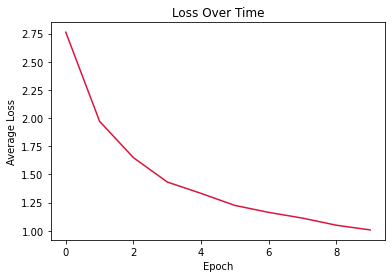

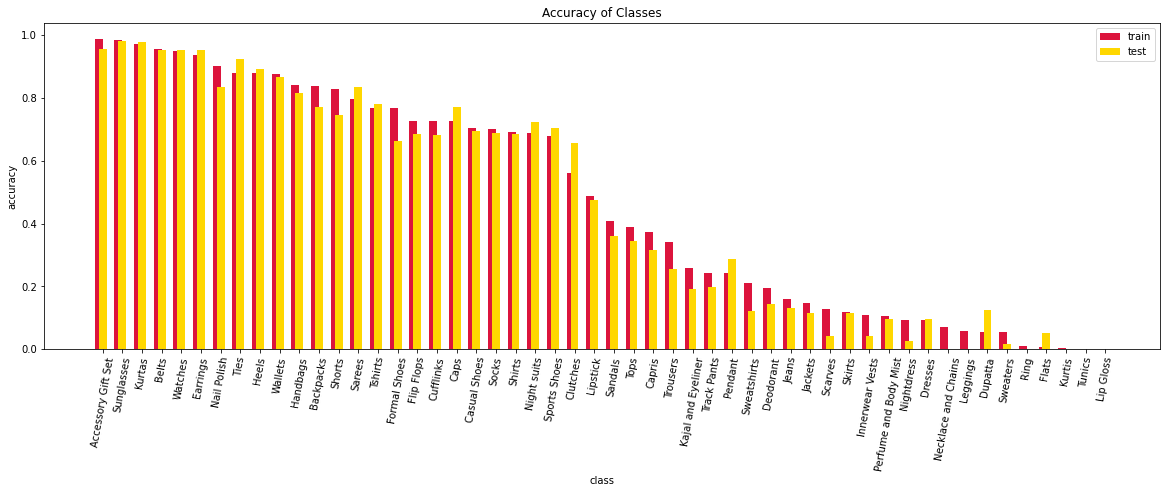

In [ ]:
neuralNetwork.fit(learningRate=0.06)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.008, time elapsed: 11.831455 seconds
epoch 2, trainLoss: 2.093, time elapsed: 11.838784 seconds
epoch 3, trainLoss: 1.754, time elapsed: 11.843395 seconds
epoch 4, trainLoss: 1.524, time elapsed: 11.824527 seconds
epoch 5, trainLoss: 1.391, time elapsed: 11.838889 seconds
epoch 6, trainLoss: 1.296, time elapsed: 11.842104 seconds
epoch 7, trainLoss: 1.215, time elapsed: 11.842187 seconds
epoch 8, trainLoss: 1.168, time elapsed: 11.841559 seconds
epoch 9, trainLoss: 1.110, time elapsed: 11.841695 seconds
epoch 10, trainLoss: 1.069, time elapsed: 11.835446 seconds
total training time: 1.973 minutes
Accuracy: 64.50749464668094%


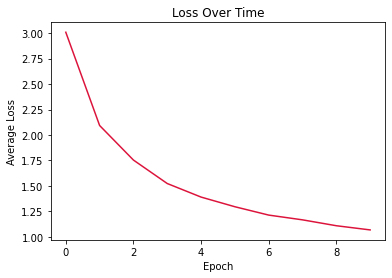

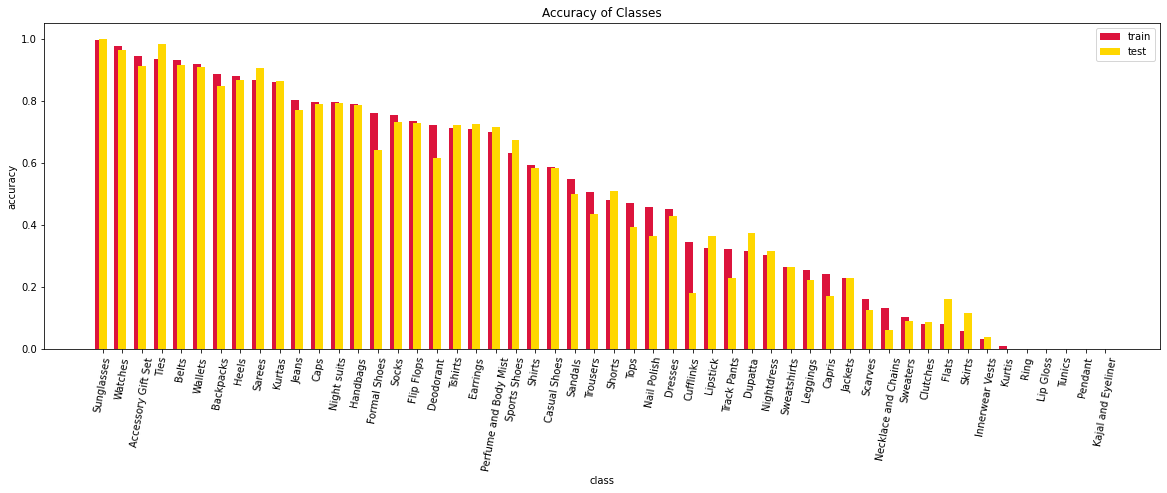

In [ ]:
neuralNetwork.fit(learningRate=0.03)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.075, time elapsed: 11.815325 seconds
epoch 2, trainLoss: 2.187, time elapsed: 11.848424 seconds
epoch 3, trainLoss: 1.807, time elapsed: 11.843018 seconds
epoch 4, trainLoss: 1.613, time elapsed: 11.839254 seconds
epoch 5, trainLoss: 1.466, time elapsed: 11.846756 seconds
epoch 6, trainLoss: 1.366, time elapsed: 11.843873 seconds
epoch 7, trainLoss: 1.288, time elapsed: 11.843054 seconds
epoch 8, trainLoss: 1.229, time elapsed: 11.838339 seconds
epoch 9, trainLoss: 1.183, time elapsed: 11.842127 seconds
epoch 10, trainLoss: 1.139, time elapsed: 11.832001 seconds
total training time: 1.973 minutes
Accuracy: 51.940578158458244%


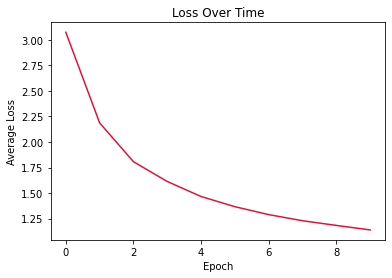

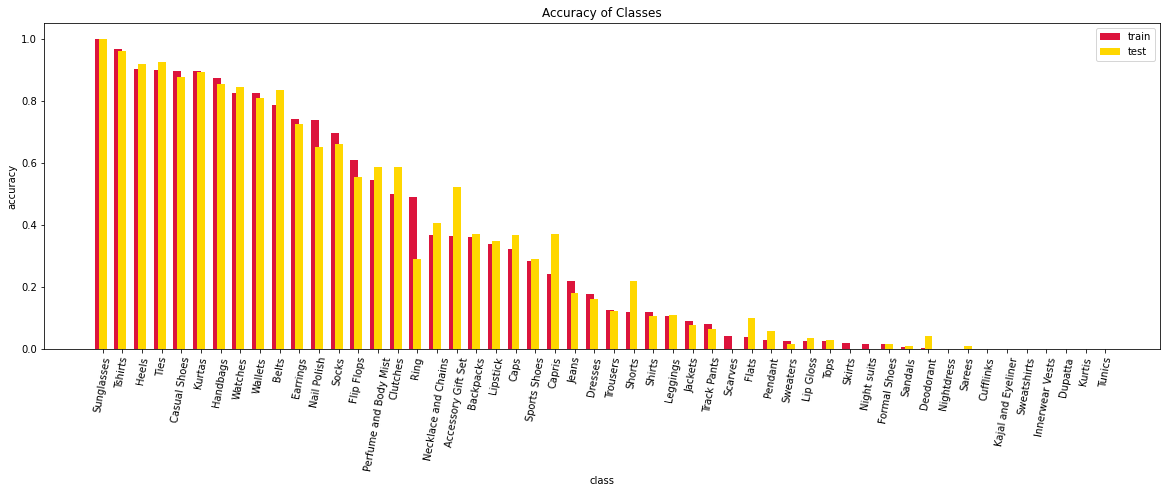

In [ ]:
neuralNetwork.fit(learningRate=0.02)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.968, time elapsed: 11.844591 seconds
epoch 2, trainLoss: 2.270, time elapsed: 11.83396 seconds
epoch 3, trainLoss: 1.864, time elapsed: 11.842239 seconds
epoch 4, trainLoss: 1.615, time elapsed: 11.839545 seconds
epoch 5, trainLoss: 1.443, time elapsed: 11.815226 seconds
epoch 6, trainLoss: 1.336, time elapsed: 11.838797 seconds
epoch 7, trainLoss: 1.270, time elapsed: 11.841099 seconds
epoch 8, trainLoss: 1.193, time elapsed: 11.836965 seconds
epoch 9, trainLoss: 1.125, time elapsed: 11.833033 seconds
epoch 10, trainLoss: 1.056, time elapsed: 11.835996 seconds
total training time: 1.973 minutes
Accuracy: 51.73982869379015%


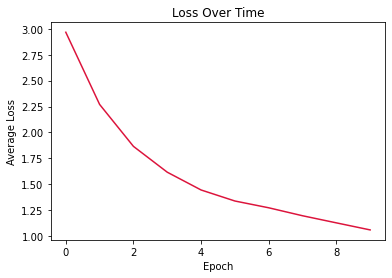

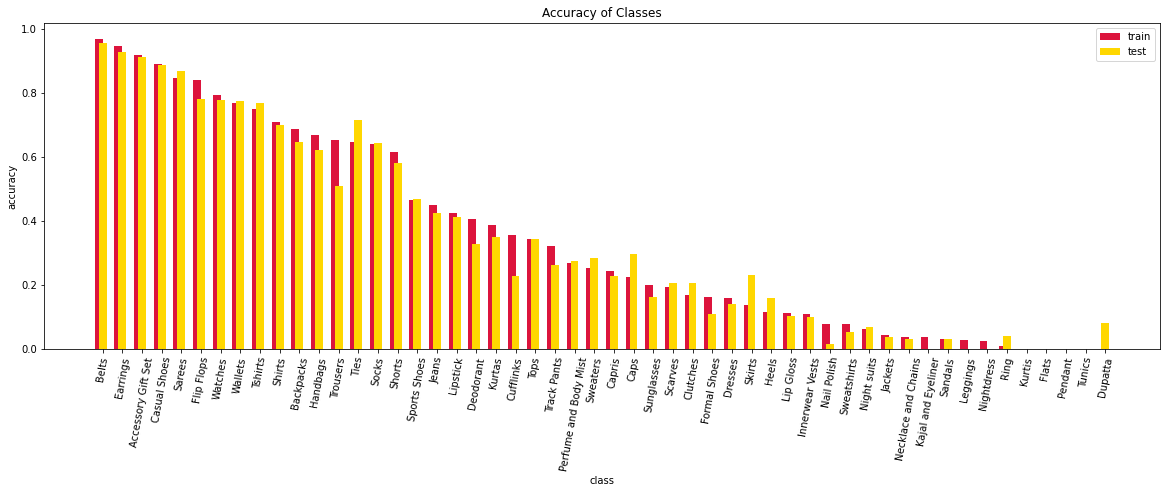

In [ ]:
neuralNetwork.fit(learningRate=0.1)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.878, time elapsed: 11.83051 seconds
epoch 2, trainLoss: 3.615, time elapsed: 11.821725 seconds
epoch 3, trainLoss: 3.475, time elapsed: 11.8464 seconds
epoch 4, trainLoss: 3.438, time elapsed: 11.836144 seconds
epoch 5, trainLoss: 3.412, time elapsed: 11.835439 seconds
epoch 6, trainLoss: 3.383, time elapsed: 11.837605 seconds
epoch 7, trainLoss: 3.337, time elapsed: 11.837172 seconds
epoch 8, trainLoss: 3.256, time elapsed: 11.847216 seconds
epoch 9, trainLoss: 3.130, time elapsed: 11.836516 seconds
epoch 10, trainLoss: 2.994, time elapsed: 11.843291 seconds
total training time: 1.973 minutes
Accuracy: 22.33672376873662%


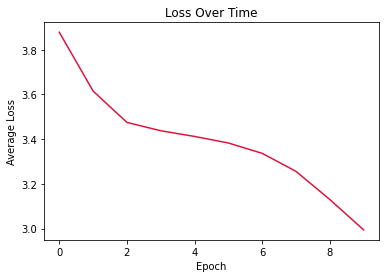

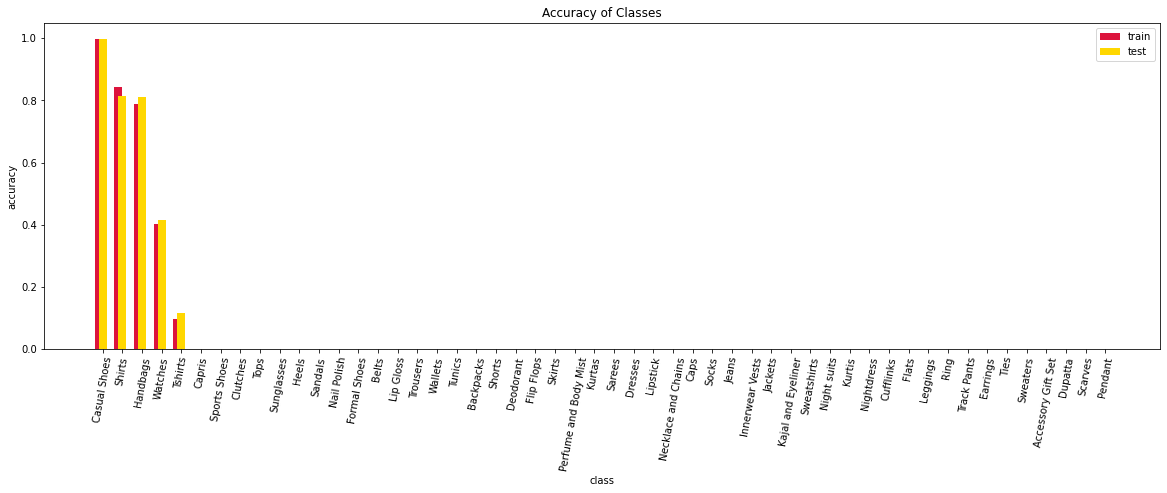

In [ ]:
neuralNetwork.fit(learningRate=0.001)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.568, time elapsed: 17.696232 seconds
epoch 2, trainLoss: 1.738, time elapsed: 17.69155 seconds
epoch 3, trainLoss: 1.450, time elapsed: 17.690538 seconds
epoch 4, trainLoss: 1.300, time elapsed: 17.689845 seconds
epoch 5, trainLoss: 1.197, time elapsed: 17.688199 seconds
epoch 6, trainLoss: 1.120, time elapsed: 17.687517 seconds
epoch 7, trainLoss: 1.052, time elapsed: 17.702034 seconds
epoch 8, trainLoss: 0.998, time elapsed: 17.690341 seconds
epoch 9, trainLoss: 0.958, time elapsed: 17.681478 seconds
epoch 10, trainLoss: 0.927, time elapsed: 17.680743 seconds
total training time: 2.948 minutes
Accuracy: 68.89721627408994%


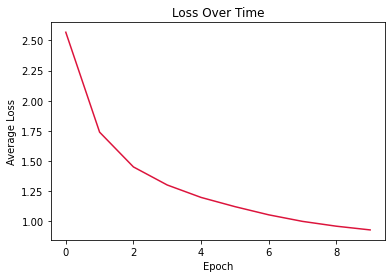

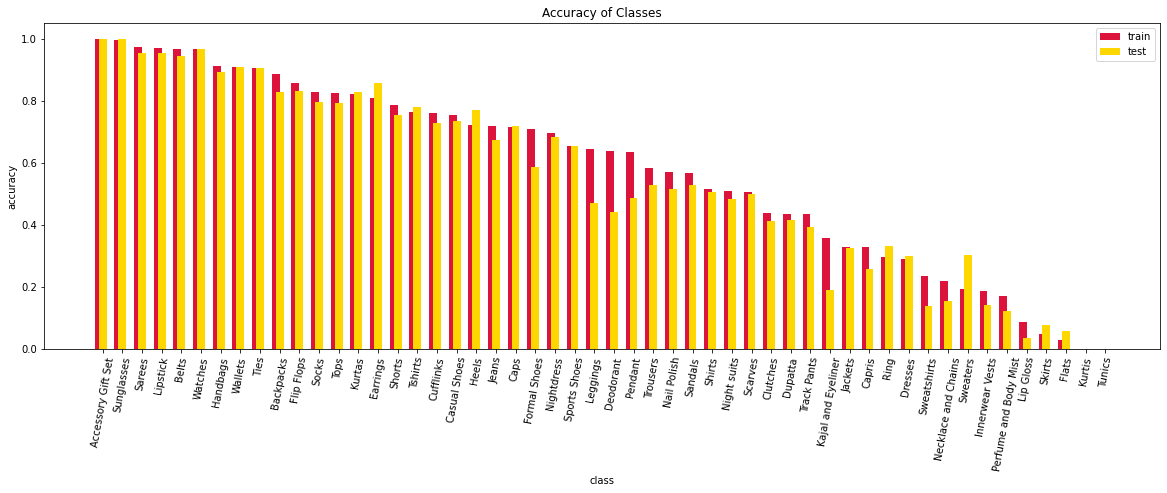

In [ ]:
neuralNetwork.setLoaders(32)
neuralNetwork.fit(learningRate=0.03)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.260, time elapsed: 9.061294 seconds
epoch 2, trainLoss: 2.465, time elapsed: 9.070419 seconds
epoch 3, trainLoss: 2.079, time elapsed: 9.075126 seconds
epoch 4, trainLoss: 1.863, time elapsed: 9.066091 seconds
epoch 5, trainLoss: 1.699, time elapsed: 9.064592 seconds
epoch 6, trainLoss: 1.579, time elapsed: 9.062281 seconds
epoch 7, trainLoss: 1.475, time elapsed: 9.057508 seconds
epoch 8, trainLoss: 1.386, time elapsed: 9.046523 seconds
epoch 9, trainLoss: 1.330, time elapsed: 9.061135 seconds
epoch 10, trainLoss: 1.263, time elapsed: 9.068507 seconds
total training time: 1.511 minutes
Accuracy: 56.15631691648822%


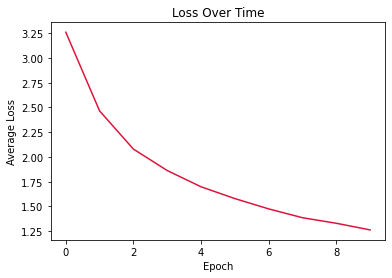

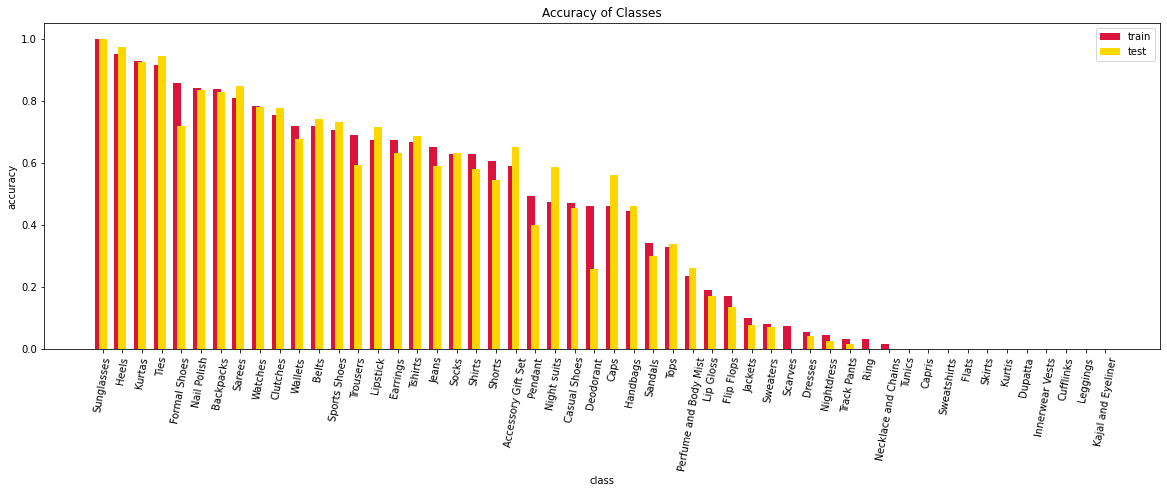

In [ ]:
neuralNetwork.setLoaders(128)
neuralNetwork.fit(learningRate=0.03)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.603, time elapsed: 9.070624 seconds
epoch 2, trainLoss: 3.151, time elapsed: 9.060149 seconds
epoch 3, trainLoss: 2.727, time elapsed: 9.050254 seconds
epoch 4, trainLoss: 2.453, time elapsed: 9.069195 seconds
epoch 5, trainLoss: 2.216, time elapsed: 9.064977 seconds
epoch 6, trainLoss: 1.990, time elapsed: 9.068658 seconds
epoch 7, trainLoss: 1.865, time elapsed: 9.057315 seconds
epoch 8, trainLoss: 1.739, time elapsed: 9.063645 seconds
epoch 9, trainLoss: 1.664, time elapsed: 9.062766 seconds
epoch 10, trainLoss: 1.581, time elapsed: 9.076378 seconds
total training time: 1.511 minutes
Accuracy: 48.23340471092077%


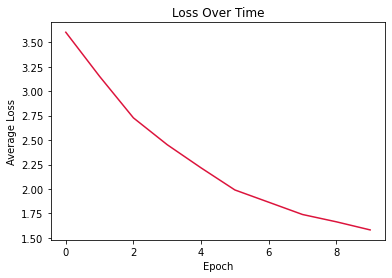

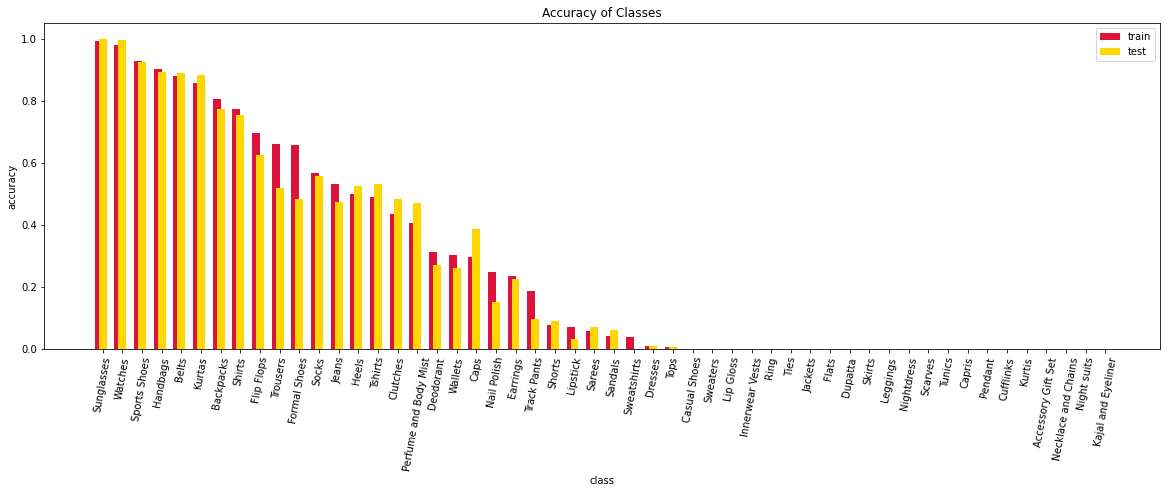

In [ ]:
neuralNetwork.fit(learningRate=0.01)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.088, time elapsed: 9.081556 seconds
epoch 2, trainLoss: 2.305, time elapsed: 9.089401 seconds
epoch 3, trainLoss: 1.984, time elapsed: 9.077362 seconds
epoch 4, trainLoss: 1.734, time elapsed: 9.078936 seconds
epoch 5, trainLoss: 1.556, time elapsed: 9.073659 seconds
epoch 6, trainLoss: 1.446, time elapsed: 9.082804 seconds
epoch 7, trainLoss: 1.370, time elapsed: 9.074082 seconds
epoch 8, trainLoss: 1.285, time elapsed: 9.055276 seconds
epoch 9, trainLoss: 1.222, time elapsed: 9.072851 seconds
epoch 10, trainLoss: 1.195, time elapsed: 9.07986 seconds
total training time: 1.513 minutes
Accuracy: 59.95717344753747%


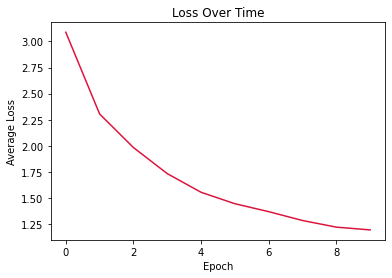

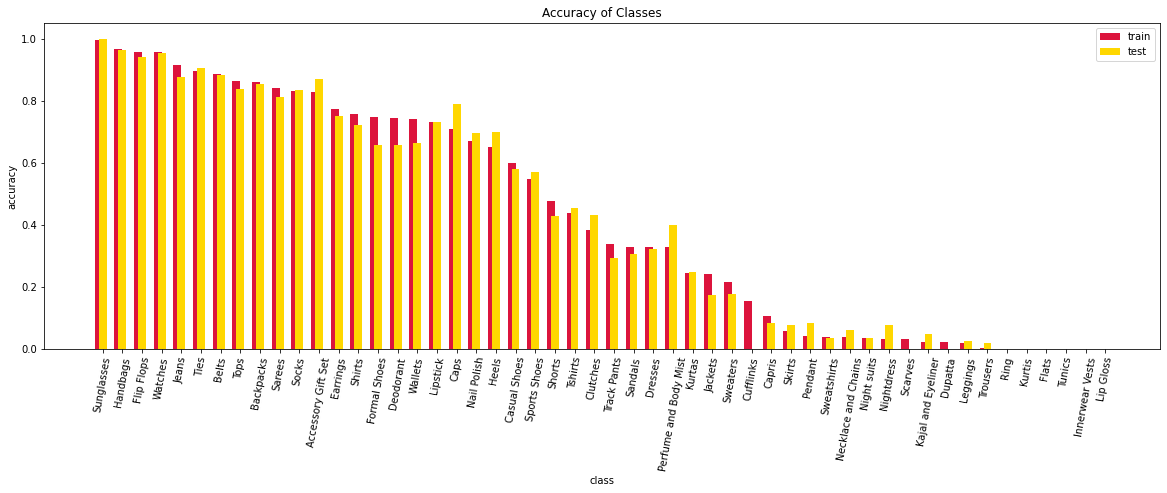

In [ ]:
neuralNetwork.fit(learningRate=0.05)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.527, time elapsed: 15.673555 seconds
epoch 2, trainLoss: 1.913, time elapsed: 15.697007 seconds
epoch 3, trainLoss: 1.827, time elapsed: 15.694954 seconds
epoch 4, trainLoss: 1.655, time elapsed: 15.723774 seconds
epoch 5, trainLoss: 1.487, time elapsed: 15.784196 seconds
epoch 6, trainLoss: 1.461, time elapsed: 15.703045 seconds
epoch 7, trainLoss: 1.398, time elapsed: 15.700989 seconds
epoch 8, trainLoss: 1.338, time elapsed: 15.703264 seconds
epoch 9, trainLoss: 1.256, time elapsed: 15.726278 seconds
epoch 10, trainLoss: 1.235, time elapsed: 15.707013 seconds
total training time: 2.619 minutes
Accuracy: 58.980192719486084%


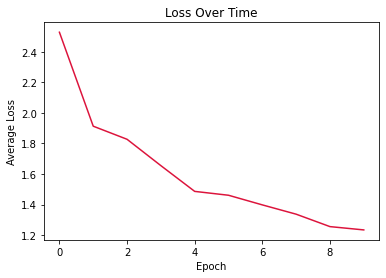

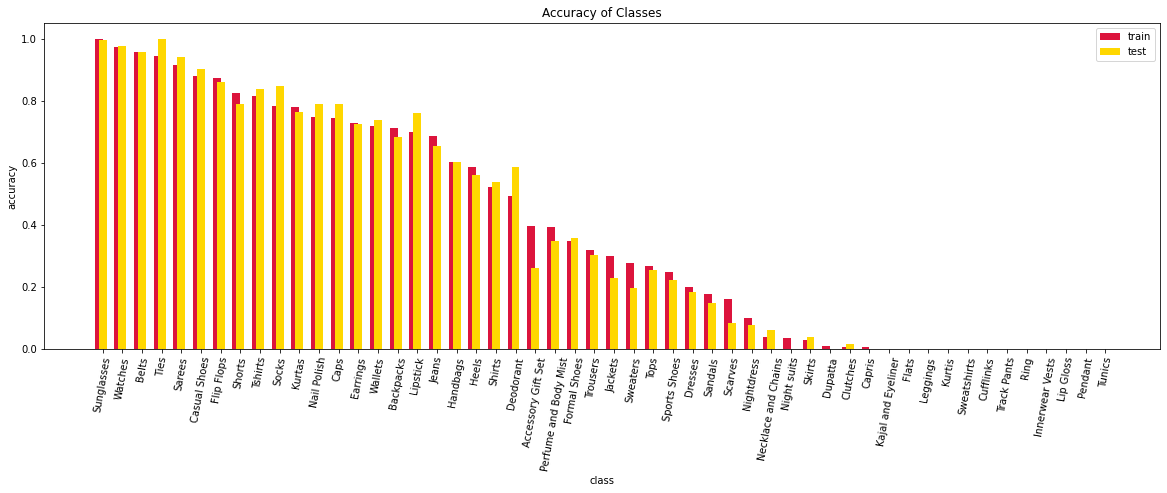

In [ ]:
neuralNetwork.setLoaders(64)
neuralNetwork.fit(learningRate = 0.03, momentum = 0.9)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.016, time elapsed: 11.845435 seconds
epoch 2, trainLoss: 2.090, time elapsed: 11.843878 seconds
epoch 3, trainLoss: 1.761, time elapsed: 11.840816 seconds
epoch 4, trainLoss: 1.549, time elapsed: 11.834993 seconds
epoch 5, trainLoss: 1.411, time elapsed: 11.839145 seconds
epoch 6, trainLoss: 1.302, time elapsed: 11.835873 seconds
epoch 7, trainLoss: 1.217, time elapsed: 11.840434 seconds
epoch 8, trainLoss: 1.164, time elapsed: 11.83829 seconds
epoch 9, trainLoss: 1.113, time elapsed: 11.844367 seconds
epoch 10, trainLoss: 1.061, time elapsed: 11.840695 seconds
total training time: 1.973 minutes
Accuracy: 61.28211991434689%


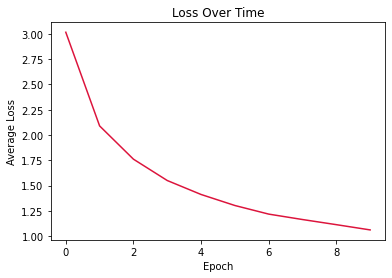

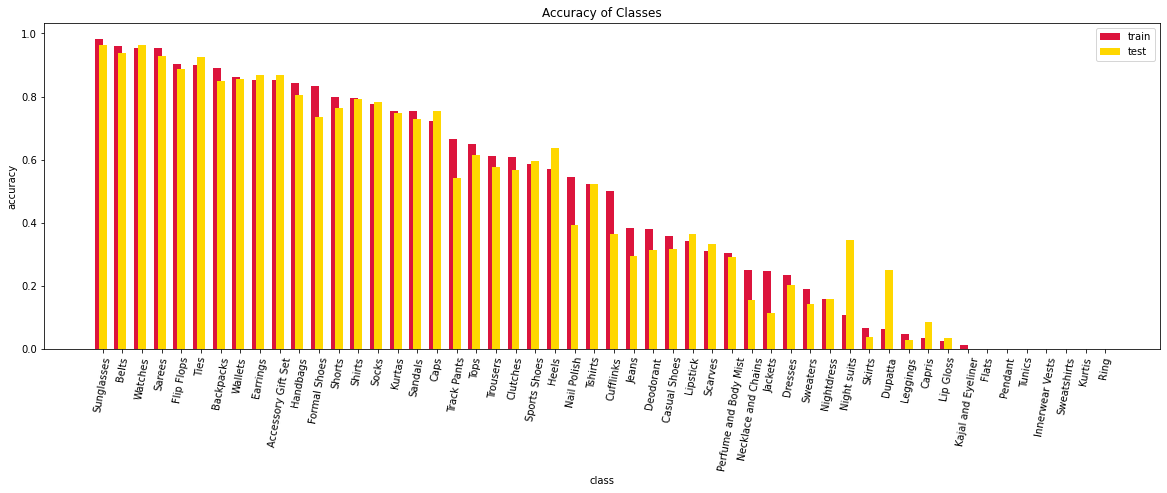

In [ ]:
neuralNetwork.fit(learningRate = 0.03)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.826, time elapsed: 11.023746 seconds
epoch 2, trainLoss: 3.162, time elapsed: 11.022022 seconds
epoch 3, trainLoss: 3.454, time elapsed: 11.037335 seconds
epoch 4, trainLoss: 3.453, time elapsed: 11.033431 seconds
epoch 5, trainLoss: 3.452, time elapsed: 11.02733 seconds
epoch 6, trainLoss: 3.452, time elapsed: 11.032608 seconds
epoch 7, trainLoss: 3.451, time elapsed: 11.038996 seconds
epoch 8, trainLoss: 3.452, time elapsed: 11.036065 seconds
epoch 9, trainLoss: 3.452, time elapsed: 11.037955 seconds
epoch 10, trainLoss: 3.452, time elapsed: 11.030408 seconds
total training time: 1.839 minutes
Accuracy: 9.461991434689507%


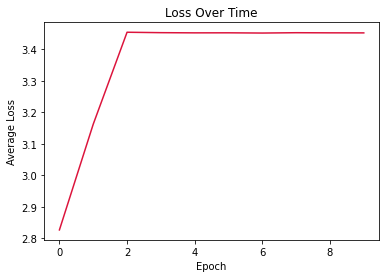

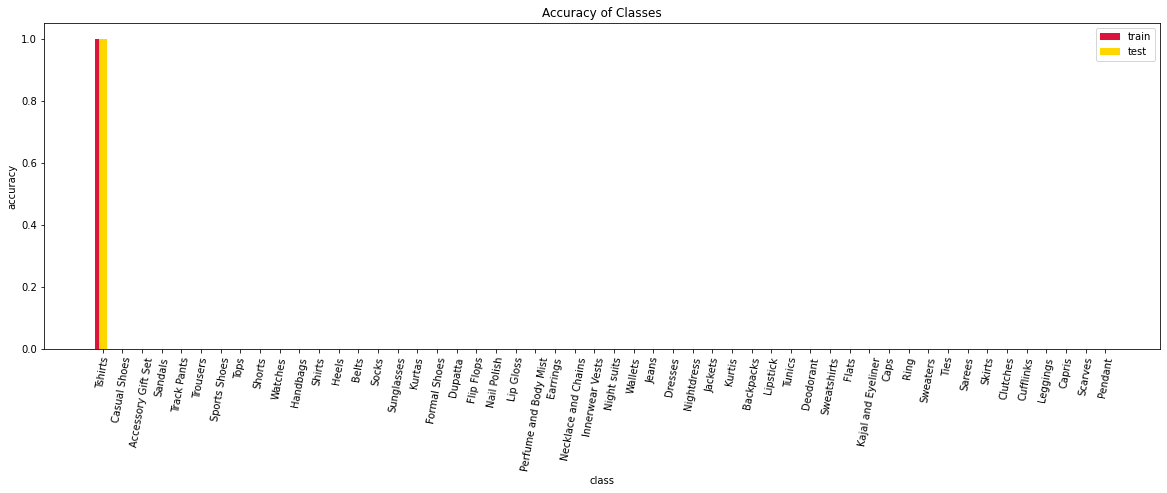

In [ ]:
neuralNetwork.fit(learningRate = 0.03, momentum = 0.98)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.879, time elapsed: 10.957195 seconds
epoch 2, trainLoss: 1.975, time elapsed: 10.960381 seconds
epoch 3, trainLoss: 1.670, time elapsed: 10.967986 seconds
epoch 4, trainLoss: 1.472, time elapsed: 11.042157 seconds
epoch 5, trainLoss: 1.343, time elapsed: 11.035224 seconds
epoch 6, trainLoss: 1.268, time elapsed: 11.032079 seconds
epoch 7, trainLoss: 1.200, time elapsed: 11.031884 seconds
epoch 8, trainLoss: 1.133, time elapsed: 11.029501 seconds
epoch 9, trainLoss: 1.092, time elapsed: 11.028406 seconds
epoch 10, trainLoss: 1.041, time elapsed: 11.037964 seconds
total training time: 1.835 minutes
Accuracy: 64.38704496788009%


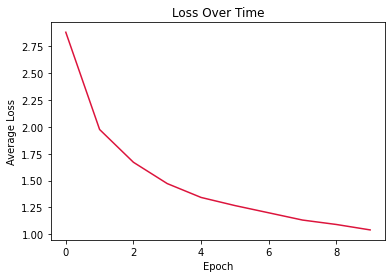

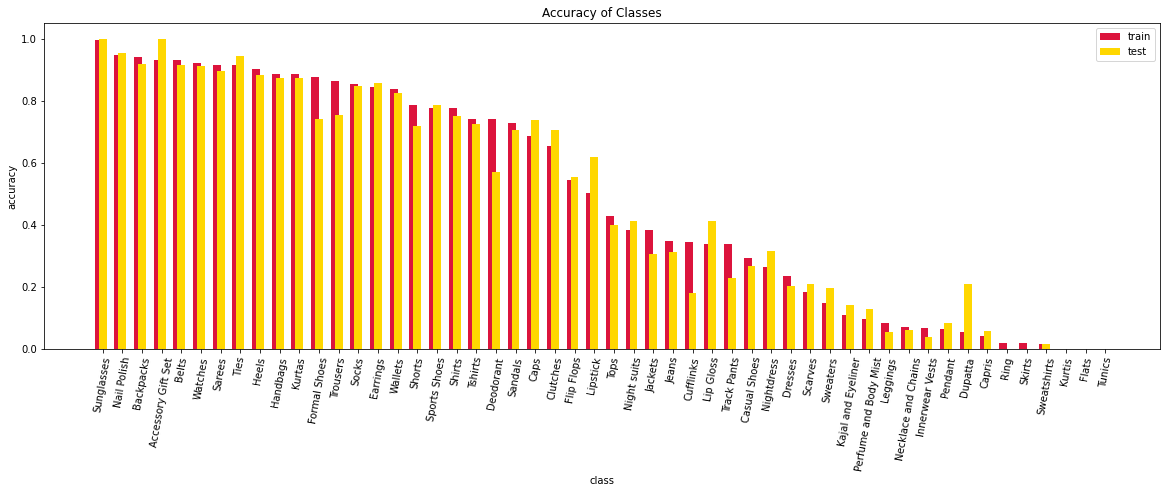

In [ ]:
neuralNetwork.fit(learningRate = 0.03, momentum = 0.5)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.829, time elapsed: 11.032976 seconds
epoch 2, trainLoss: 2.186, time elapsed: 11.036811 seconds
epoch 3, trainLoss: 1.843, time elapsed: 11.026453 seconds
epoch 4, trainLoss: 1.622, time elapsed: 11.028282 seconds
epoch 5, trainLoss: 1.480, time elapsed: 11.029176 seconds
epoch 6, trainLoss: 1.394, time elapsed: 11.023871 seconds
epoch 7, trainLoss: 1.291, time elapsed: 11.005435 seconds
epoch 8, trainLoss: 1.258, time elapsed: 11.032474 seconds
epoch 9, trainLoss: 1.212, time elapsed: 11.016355 seconds
epoch 10, trainLoss: 1.169, time elapsed: 11.019082 seconds
epoch 11, trainLoss: 1.118, time elapsed: 11.026495 seconds
epoch 12, trainLoss: 1.070, time elapsed: 11.019466 seconds
epoch 13, trainLoss: 1.044, time elapsed: 11.019274 seconds
epoch 14, trainLoss: 1.000, time elapsed: 11.028008 seconds
epoch 15, trainLoss: 0.971, time elapsed: 11.023178 seconds
epoch 16, trainLoss: 0.955, time elapsed: 11.016946 seconds
epoch 17, trainLoss: 0.952, time elapsed: 11.0045

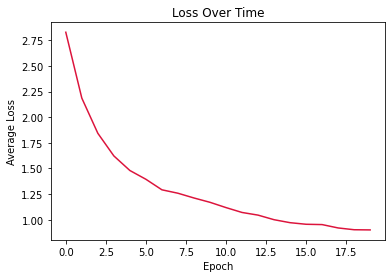

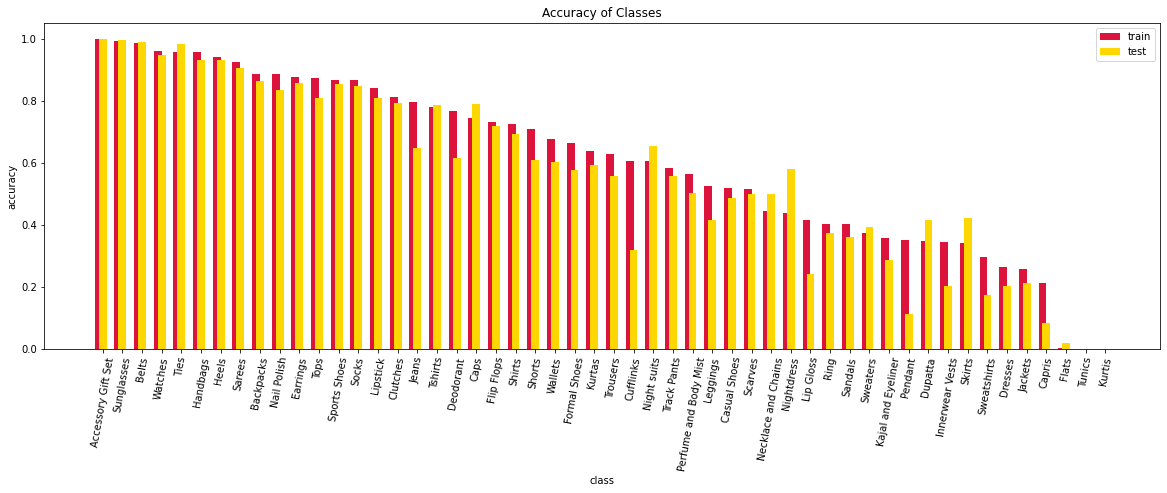

In [ ]:
neuralNetwork.fit(learningRate = 0.03, numEpochs = 20, momentum = 0.5)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.637, time elapsed: 11.016402 seconds
epoch 2, trainLoss: 1.801, time elapsed: 11.026 seconds
epoch 3, trainLoss: 1.608, time elapsed: 11.027646 seconds
epoch 4, trainLoss: 1.484, time elapsed: 11.020728 seconds
epoch 5, trainLoss: 1.402, time elapsed: 11.026403 seconds
epoch 6, trainLoss: 1.305, time elapsed: 11.019661 seconds
epoch 7, trainLoss: 1.254, time elapsed: 11.019802 seconds
epoch 8, trainLoss: 1.182, time elapsed: 11.021965 seconds
epoch 9, trainLoss: 1.137, time elapsed: 10.996284 seconds
epoch 10, trainLoss: 1.106, time elapsed: 11.024019 seconds
total training time: 1.837 minutes
Accuracy: 60.07762312633833%


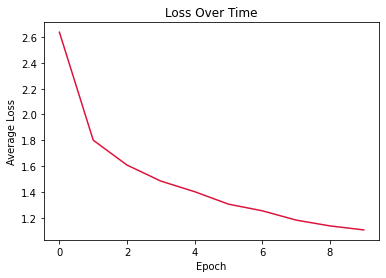

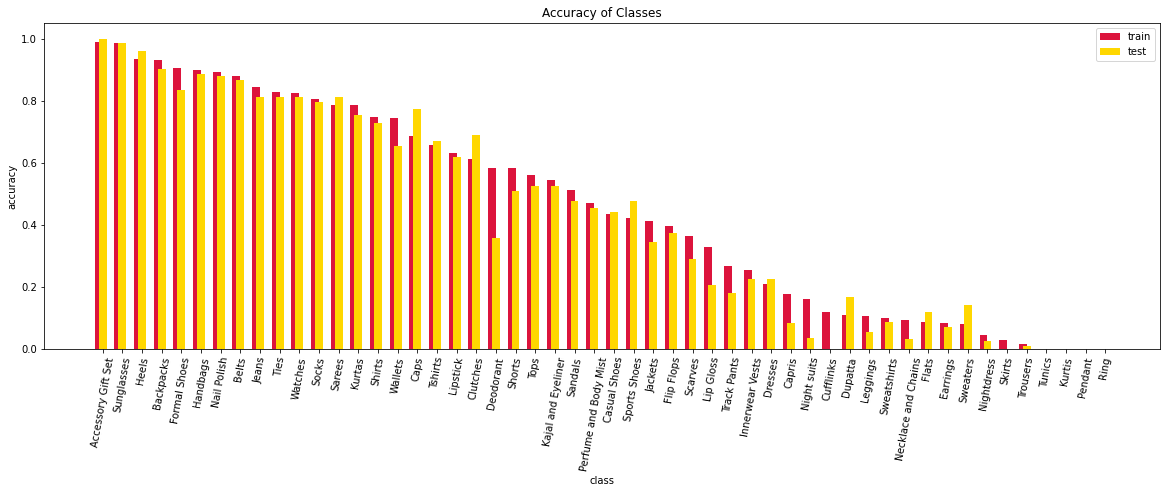

In [ ]:
neuralNetwork.fit(learningRate = 0.03, momentum = 0.5, act = torch.tanh)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.612, time elapsed: 11.017285 seconds
epoch 2, trainLoss: 1.932, time elapsed: 11.010647 seconds
epoch 3, trainLoss: 1.630, time elapsed: 11.017667 seconds
epoch 4, trainLoss: 1.477, time elapsed: 11.012634 seconds
epoch 5, trainLoss: 1.381, time elapsed: 11.023381 seconds
epoch 6, trainLoss: 1.309, time elapsed: 11.019288 seconds
epoch 7, trainLoss: 1.250, time elapsed: 11.021588 seconds
epoch 8, trainLoss: 1.179, time elapsed: 11.024373 seconds
epoch 9, trainLoss: 1.102, time elapsed: 11.020037 seconds
epoch 10, trainLoss: 1.084, time elapsed: 11.021049 seconds
total training time: 1.836 minutes
Accuracy: 62.95503211991435%


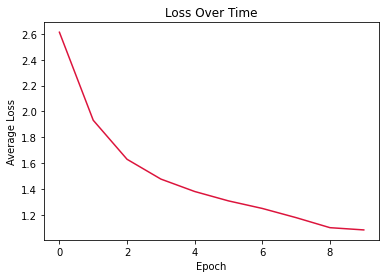

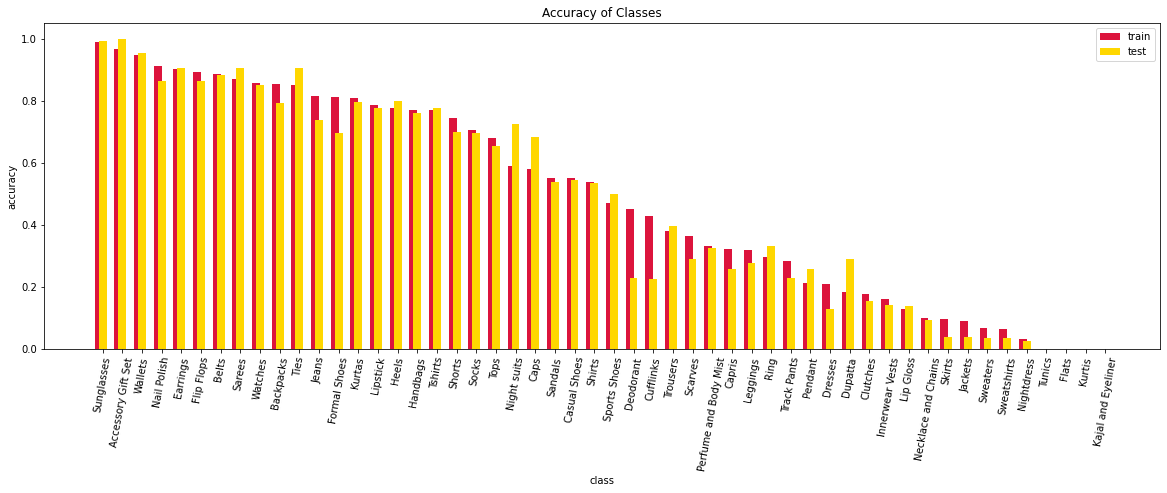

In [ ]:
neuralNetwork.fit(learningRate = 0.03, momentum = 0.5, act = F.leaky_relu)
neuralNetwork.evaluate()

epoch 1, trainLoss: 3.443, time elapsed: 12.162302 seconds
epoch 2, trainLoss: 3.348, time elapsed: 12.178551 seconds
epoch 3, trainLoss: 3.371, time elapsed: 12.179264 seconds
epoch 4, trainLoss: 3.386, time elapsed: 12.187908 seconds
epoch 5, trainLoss: 3.398, time elapsed: 12.178821 seconds
epoch 6, trainLoss: 3.376, time elapsed: 12.184148 seconds
epoch 7, trainLoss: 3.373, time elapsed: 12.179184 seconds
epoch 8, trainLoss: 3.385, time elapsed: 12.182443 seconds
epoch 9, trainLoss: 3.371, time elapsed: 12.17232 seconds
epoch 10, trainLoss: 3.376, time elapsed: 12.178928 seconds
total training time: 2.030 minutes
Accuracy: 8.712526766595289%


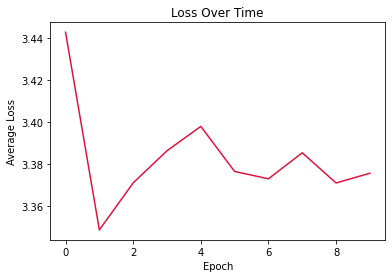

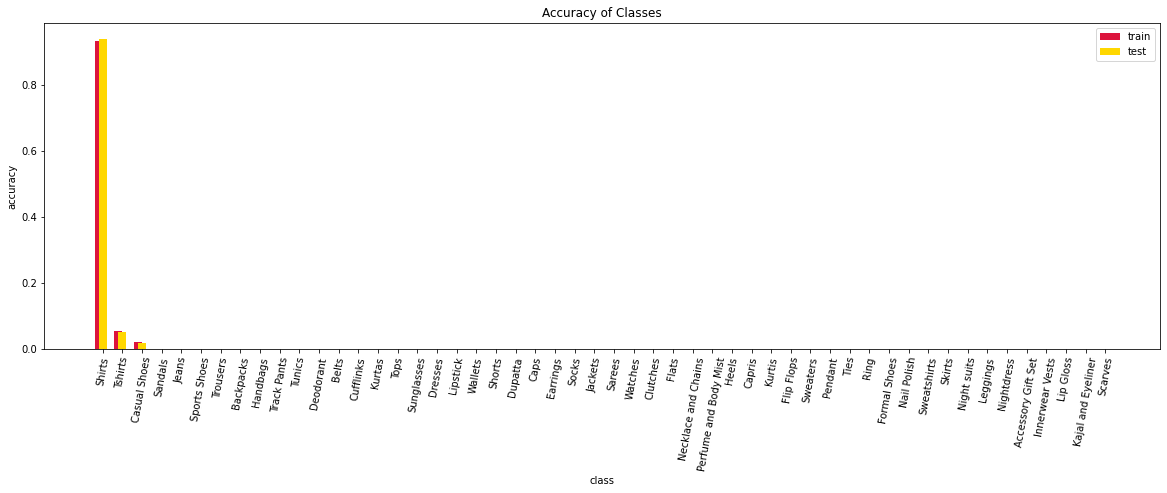

In [ ]:
neuralNetwork.fit(learningRate = 0.03, momentum = 0.5, weightDecay = 0.1)
neuralNetwork.evaluate()

epoch 1, trainLoss: 2.714, time elapsed: 12.184716 seconds
epoch 2, trainLoss: 2.172, time elapsed: 12.184403 seconds
epoch 3, trainLoss: 2.004, time elapsed: 12.184006 seconds
epoch 4, trainLoss: 1.988, time elapsed: 12.162769 seconds
epoch 5, trainLoss: 2.007, time elapsed: 12.174574 seconds
epoch 6, trainLoss: 1.897, time elapsed: 12.186989 seconds
epoch 7, trainLoss: 1.875, time elapsed: 12.179558 seconds
epoch 8, trainLoss: 1.850, time elapsed: 12.179192 seconds
epoch 9, trainLoss: 1.830, time elapsed: 12.178532 seconds
epoch 10, trainLoss: 1.973, time elapsed: 12.185234 seconds
total training time: 2.030 minutes
Accuracy: 39.694860813704494%


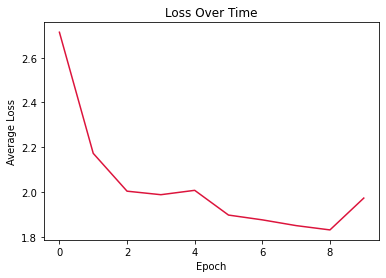

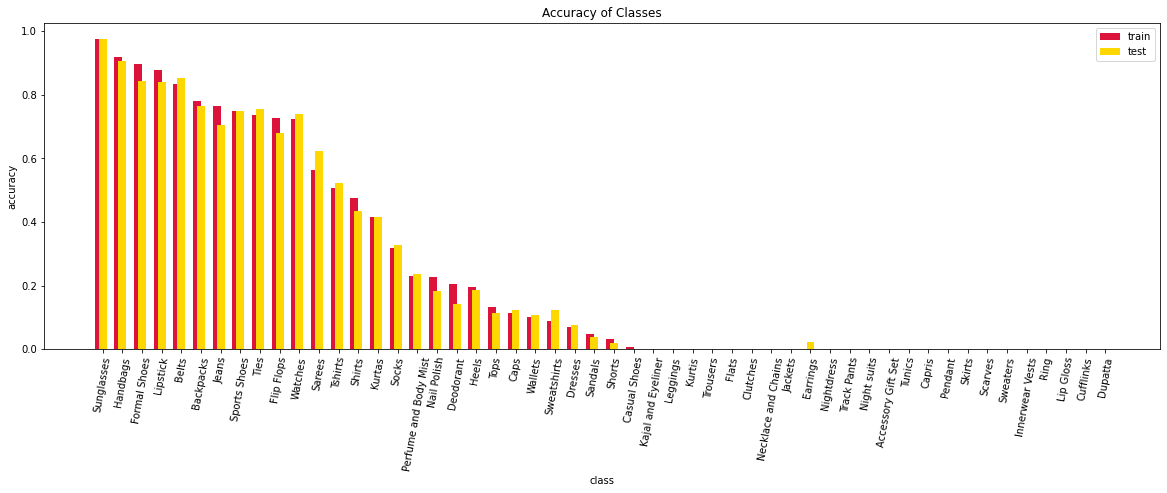

In [ ]:
neuralNetwork.fit(learningRate = 0.03, momentum = 0.5, weightDecay = 0.01)
neuralNetwork.evaluate()